In [61]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy.coordinates import Distance
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval

In [62]:
# --- Load Gaia cone catalog ---
tab = Table.read("Cone_GaiaDR3.fits", hdu=1)
ra  = np.array(tab["ra"], float)
dec = np.array(tab["dec"], float)
good = np.isfinite(ra) & np.isfinite(dec)
ra, dec = ra[good], dec[good]

# --- Spherical mean center of the catalog (robust to RA wrap) ---
ra_rad  = np.deg2rad(ra)
dec_rad = np.deg2rad(dec)

x = np.cos(dec_rad) * np.cos(ra_rad)
y = np.cos(dec_rad) * np.sin(ra_rad)
z = np.sin(dec_rad)

x_m, y_m, z_m = x.mean(), y.mean(), z.mean()
r = np.sqrt(x_m**2 + y_m**2 + z_m**2)
x_m, y_m, z_m = x_m/r, y_m/r, z_m/r

ra_center  = (np.rad2deg(np.arctan2(y_m, x_m)) + 360.0) % 360.0
dec_center = np.rad2deg(np.arctan2(z_m, np.hypot(x_m, y_m)))

c_center_icrs = SkyCoord(ra_center*u.deg, dec_center*u.deg, frame="icrs")
c_center_gal = c_center_icrs.galactic


In [63]:
print(f"Gaia catalog center (ICRS): RA = {c_center_icrs.ra.deg:.6f}°, Dec = {c_center_icrs.dec.deg:.6f}°")
print(f"Gaia catalog center (Galactic): l = {c_center_gal.l.deg:.6f}°, b = {c_center_gal.b.deg:.6f}°")


Gaia catalog center (ICRS): RA = 280.689186°, Dec = -4.034255°
Gaia catalog center (Galactic): l = 28.352643°, b = 0.088252°


In [64]:
# --- Load Spitzer image (Galactic WCS) ---
with fits.open("GLM_02850_0000_mosaic_I1.fits") as hdul:
    wcs  = WCS(hdul[0].header)
    data = hdul[0].data

# --- Load Gaia (ICRS) and convert to Galactic ---
tab = Table.read("Cone_GaiaDR3.fits", hdu=1)
ra  = np.array(tab["ra"], float)
dec = np.array(tab["dec"], float)
good = np.isfinite(ra) & np.isfinite(dec)
c_icrs = SkyCoord(ra[good]*u.deg, dec[good]*u.deg, frame="icrs")
c_gal  = c_icrs.galactic
l = c_gal.l.deg
b = c_gal.b.deg

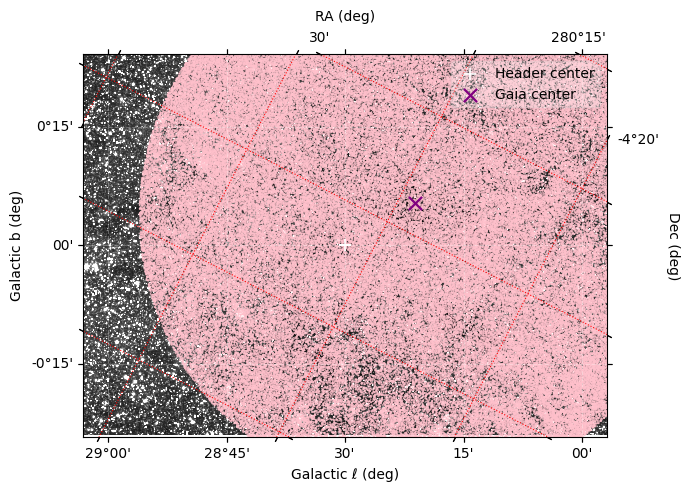

In [65]:
# --- Plot: Galactic image with RA/Dec overlay ticks ---
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(projection=wcs)

vmin, vmax = ZScaleInterval().get_limits(data)
im = ax.imshow(data, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)

# lock limits so scatter won't autoscale
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.autoscale(False)

# gaia scatter (low zorder so overlays can sit above)
sc = ax.scatter(l, b,
                transform=ax.get_transform("galactic"),
                s=0.6, facecolors="none", edgecolors="pink", lw=0.4,
                zorder=0.5, clip_on=True)
sc.set_clip_path(ax.patch)
ax.set_xlim(xlim); ax.set_ylim(ylim)

# centers: header (CRVAL) and data center
crval = wcs.wcs.crval  # native WCS coords (ℓ,b here)
ny, nx = data.shape
cx, cy = nx/2.0, ny/2.0
center_world = wcs.pixel_to_world(cx, cy).galactic
ax.scatter([crval[0]], [crval[1]], transform=ax.get_transform("world"),
           s=70, marker="+", color="white", lw=1.2, zorder=4, label="Header center")
# on your existing axes 'ax' with Galactic WCS:
ax.scatter([c_center_gal.l.deg], [c_center_gal.b.deg],
           transform=ax.get_transform("galactic"),
           s=90, marker="x", color="purple", lw=1.6, zorder=5, label="Gaia center")
ax.legend(loc="upper right", frameon=True, framealpha=0.25)

# labels/grid
ax.set_xlabel("Galactic ℓ (deg)"); ax.set_ylabel("Galactic b (deg)")
ax.coords.grid(color="white", ls="--", alpha=0.3)

# RA/Dec overlay (no reprojection)
overlay = ax.get_coords_overlay("icrs")
overlay[0].set_axislabel("RA (deg)")
overlay[1].set_axislabel("Dec (deg)")
overlay.grid(color="red", ls=":", alpha=1.0)  # drawn after scatter → appears on top

ax.legend(loc="upper right", frameon=True, framealpha=0.25)
plt.tight_layout(); plt.show()
